# Import Libraries

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

# Defining Labels

# Loading Dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import kagglehub

# Download latest version
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_root)

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# In this dataset, folders are usually: .../Training and .../Testing
train_dir = os.path.join(dataset_root, "Training")
test_dir  = os.path.join(dataset_root, "Testing")

image_size = 224

X_train, Y_train = [], []
X_test, Y_test = [], []

def load_split(data_dir, X, Y):
    for label in labels:
        class_num = labels.index(label)
        class_dir = os.path.join(data_dir, label)

        if not os.path.isdir(class_dir):
            raise FileNotFoundError(f"Missing folder: {class_dir}")

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            try:
                img_array = plt.imread(img_path)

                # If grayscale, convert to 3 channels
                if img_array.ndim == 2:
                    img_array = np.stack([img_array]*3, axis=-1)

                # If RGBA, drop alpha channel
                if img_array.shape[-1] == 4:
                    img_array = img_array[..., :3]

                img_resized = resize(img_array, (image_size, image_size, 3),
                                     preserve_range=True, anti_aliasing=True)

                X.append(img_resized.astype(np.float32))
                Y.append(class_num)

            except Exception as e:
                print(f"Skipping {img_path}: {e}")

# Load train and test
load_split(train_dir, X_train, Y_train)
load_split(test_dir,  X_test,  Y_test)

X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.int64)

X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.int64)

# Optional: normalize to [0,1] if your images are in 0-255
if X_train.max() > 1.5:
    X_train /= 255.0
    X_test  /= 255.0

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Train: (5712, 224, 224, 3) (5712,)
Test : (1311, 224, 224, 3) (1311,)


# Ploting Some Images

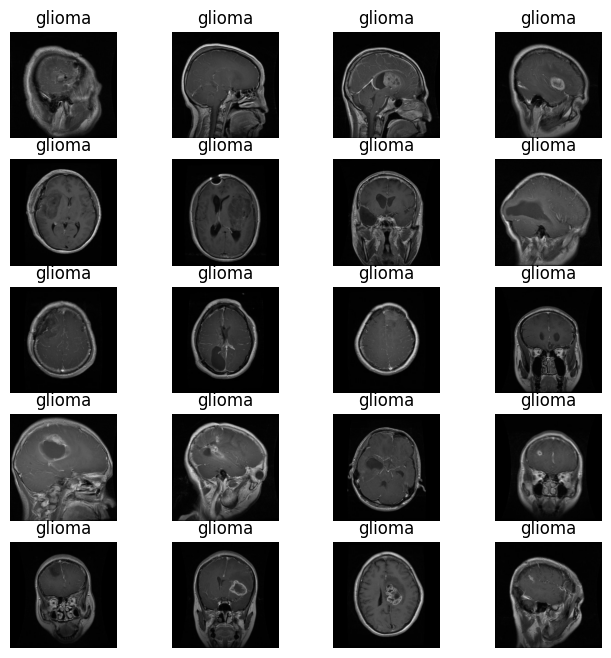

In [ ]:
#plotting the images
plt.figure(figsize=(8,8))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio

In [ ]:
# Split the data into training and testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# converting string to categorica

In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# convert string to categorical
y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)


# Load pre-trained Model ResNet50

In [ ]:
from keras.applications import ResNet50

# Load ResNet50 model with pre-trained weights
base_model = ResNet50(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Unfreeze some layers in the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('Bmodel.h5', monitor='val_loss', save_best_only=True)

# Model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Training the model

In [ ]:
# Fit the model
history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32),
                    epochs=50,  # Increase the number of epochs as needed
                    validation_data=(X_valid, y_valid_new),
                    callbacks=[early_stopping, checkpoint])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.5748 - loss: 1.1580

129/129 ━━━━━━━━━━━━━━━━━━━━ 151s 706ms/step - accuracy: 0.5758 - loss: 1.1552 - val_accuracy: 0.2560 - val_loss: 1.6821
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8519 - loss: 0.4164

129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.8520 - loss: 0.4161 - val_accuracy: 0.2954 - val_loss: 1.6370
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8871 - loss: 0.3083

129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 508ms/step - accuracy: 0.8872 - loss: 0.3081 - val_accuracy: 0.2932 - val_loss: 1.5986
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9265 - loss: 0.2045

129/129 ━━━━━━━━━━━━━━━━━━━━ 64s 491ms/step - accuracy: 0.9265 - loss: 0.2047 - val_accuracy: 0.4179 - val_loss: 1.4543
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - accuracy: 0.9369 - loss: 0.1886 - val_accuracy: 0.4442 - val_loss: 1.5427
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9541 - loss: 0.1355

129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 517ms/step - accuracy: 0.9541 - loss: 0.1355 - val_accuracy: 0.5252 - val_loss: 1.4433
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9583 - loss: 0.1333

129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 483ms/step - accuracy: 0.9583 - loss: 0.1333 - val_accuracy: 0.5799 - val_loss: 1.3071
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9580 - loss: 0.1240

129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 517ms/step - accuracy: 0.9580 - loss: 0.1239 - val_accuracy: 0.6521 - val_loss: 1.0153
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9690 - loss: 0.1032

129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 545ms/step - accuracy: 0.9691 - loss: 0.1031 - val_accuracy: 0.8468 - val_loss: 0.4832
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9651 - loss: 0.0999

129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 516ms/step - accuracy: 0.9651 - loss: 0.0999 - val_accuracy: 0.8665 - val_loss: 0.4417
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9770 - loss: 0.0728

129/129 ━━━━━━━━━━━━━━━━━━━━ 87s 556ms/step - accuracy: 0.9770 - loss: 0.0728 - val_accuracy: 0.8993 - val_loss: 0.3494
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9850 - loss: 0.0563

129/129 ━━━━━━━━━━━━━━━━━━━━ 72s 555ms/step - accuracy: 0.9850 - loss: 0.0564 - val_accuracy: 0.9256 - val_loss: 0.2629
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9827 - loss: 0.0607

129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 545ms/step - accuracy: 0.9827 - loss: 0.0607 - val_accuracy: 0.9628 - val_loss: 0.1021
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - accuracy: 0.9814 - loss: 0.0593 - val_accuracy: 0.9781 - val_loss: 0.1203
Epoch 15/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9861 - loss: 0.0447

129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 538ms/step - accuracy: 0.9861 - loss: 0.0448 - val_accuracy: 0.9737 - val_loss: 0.0833
Epoch 16/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9877 - loss: 0.0416

129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 536ms/step - accuracy: 0.9876 - loss: 0.0416 - val_accuracy: 0.9759 - val_loss: 0.0756
Epoch 17/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9852 - loss: 0.0460

129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 541ms/step - accuracy: 0.9852 - loss: 0.0460 - val_accuracy: 0.9803 - val_loss: 0.0514
Epoch 18/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - accuracy: 0.9878 - loss: 0.0427 - val_accuracy: 0.9672 - val_loss: 0.1283
Epoch 19/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - accuracy: 0.9861 - loss: 0.0473 - val_accuracy: 0.9781 - val_loss: 0.0800
Epoch 20/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 60s 461ms/step - accuracy: 0.9913 - loss: 0.0314 - val_accuracy: 0.9759 - val_loss: 0.1346
Epoch 21/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9915 - loss: 0.0343 - val_accuracy: 0.9781 - val_loss: 0.0898
Epoch 22/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 60s 461ms/step - accuracy: 0.9877 - loss: 0.0449 - val_accuracy: 0.9759 - val_loss: 0.0989


# Save the model

In [ ]:
# Load the best model
model = load_model('Bmodel.h5')

# Accurcy and Loss visualization

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9861 - loss: 0.0601


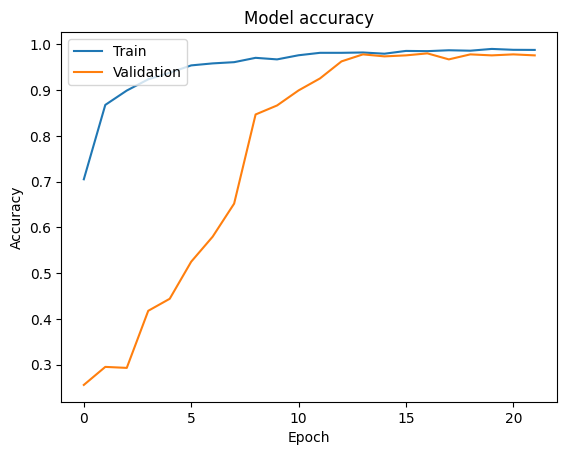

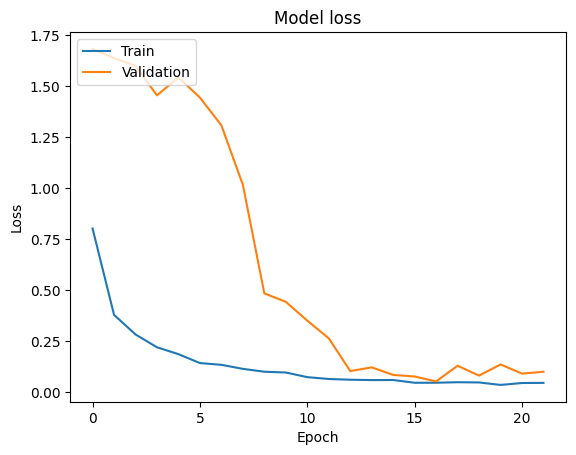

In [ ]:
#Evaluate the model
model.evaluate(X_test, y_test_new)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion matrix

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step


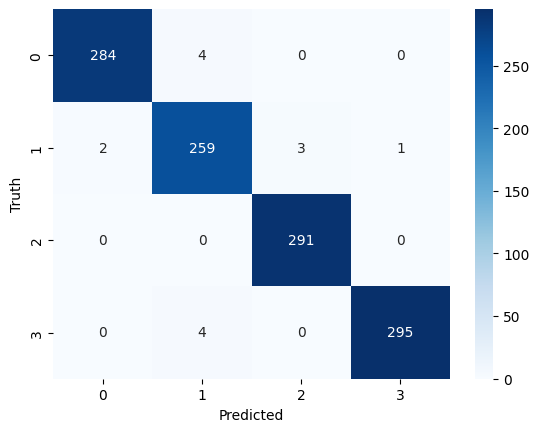

In [ ]:
# Predict the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification report

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       288
  meningioma       0.97      0.98      0.97       265
     notumor       0.99      1.00      0.99       291
   pituitary       1.00      0.99      0.99       299

    accuracy                           0.99      1143
   macro avg       0.99      0.99      0.99      1143
weighted avg       0.99      0.99      0.99      1143



# Visualizing Model Predictions

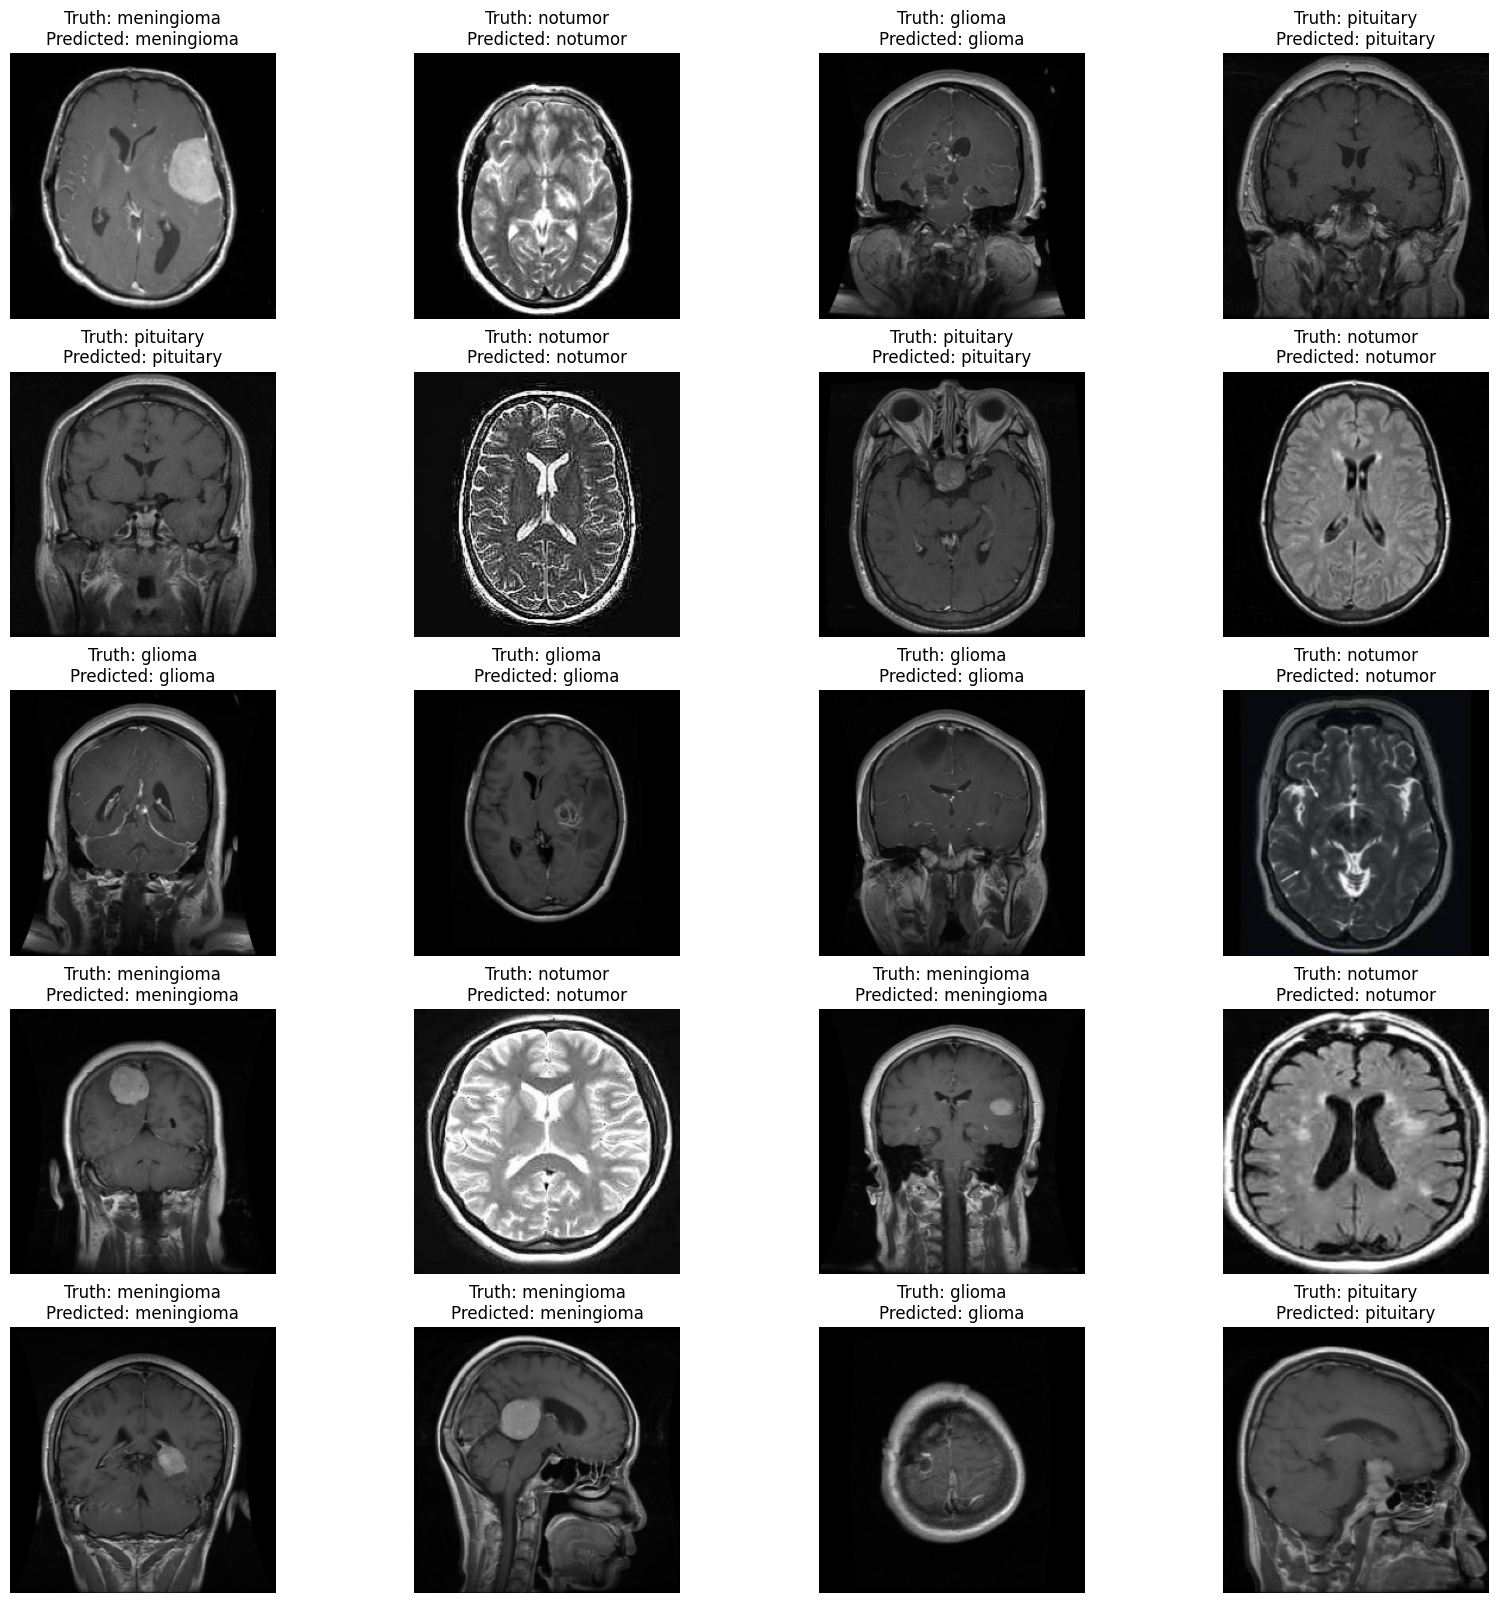

In [ ]:
# Visualizing Model Predictions
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred[i]]}")
    plt.axis('off')
plt.show()

In [ ]:
#testing accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred))

0.9877515310586177


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = Y_test

labels_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

report = classification_report(
    y_true,
    y_pred,
    target_names=labels_names,
    digits=4
)

print(report)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
              precision    recall  f1-score   support

      glioma     0.9930    0.9861    0.9895       288
  meningioma     0.9700    0.9774    0.9737       265
     notumor     0.9898    1.0000    0.9949       291
   pituitary     0.9966    0.9866    0.9916       299

    accuracy                         0.9878      1143
   macro avg     0.9874    0.9875    0.9874      1143
weighted avg     0.9878    0.9878    0.9878      1143



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# y_true = Y_test
# y_pred = np.argmax(model.predict(X_test), axis=1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro    = recall_score(y_true, y_pred, average='macro')
f1_macro        = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted    = recall_score(y_true, y_pred, average='weighted')
f1_weighted        = f1_score(y_true, y_pred, average='weighted')

print("Métriques agrégées :")
print(f"Precision macro: {precision_macro:.4f}")
print(f"Recall macro: {recall_macro:.4f}")
print(f"F1-score macro: {f1_macro:.4f}")
print(f"Precision weighted: {precision_weighted:.4f}")
print(f"Recall weighted: {recall_weighted:.4f}")
print(f"F1-score weighted: {f1_weighted:.4f}")

PU_macro = precision_score(y_true, y_pred, average='macro')
print("PU moyenne (macro):", f"{PU_macro:.4f}")
PA_micro = recall_score(y_true, y_pred, average='micro')
print("PA moyenne (micro):", f"{PA_micro:.4f}")



Métriques agrégées :
Precision macro: 0.9874
Recall macro: 0.9875
F1-score macro: 0.9874
Precision weighted: 0.9878
Recall weighted: 0.9878
F1-score weighted: 0.9878
PU moyenne (macro): 0.9874
PA moyenne (micro): 0.9878


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


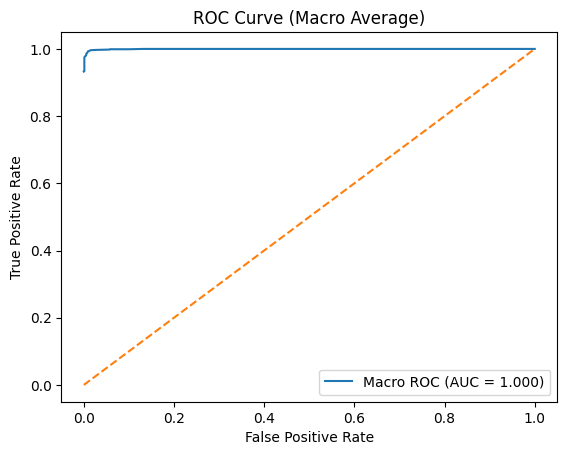

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

n_classes = 4
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])
y_score = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot(all_fpr, mean_tpr, label=f"Macro ROC (AUC = {roc_auc_macro:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Macro Average)")
plt.legend()
plt.show()


In [ ]:
a